# Entrenamiento del modelo 

In [18]:
### En el entrenamiento se evaluaran los 3 modelos principales. Se eligió hacer validación cruzada por el número reducido de datos. 

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import multiprocessing
multiprocessing.set_start_method('fork', force=True)
import shap

In [20]:
# Importaciones de sklearn y otros módulos
from sklearn.model_selection import (StratifiedKFold, cross_validate, 
                                     cross_val_predict, RandomizedSearchCV, 
                                     learning_curve)
from sklearn.metrics import (confusion_matrix, roc_auc_score, accuracy_score, 
                             precision_score, recall_score, f1_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance

In [21]:
# Función para evaluar un modelo

def evaluate_model(model, X, y, cv=5, random_state=42):
    """
    Realiza validación cruzada estratificada y calcula las métricas de evaluación:
    ROC AUC, Accuracy, Precision, Recall y F1-Score.
    Además, calcula la matriz de confusión usando cross_val_predict.
    """
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    scoring = ['roc_auc', 'accuracy', 'precision', 'recall', 'f1']
    
    # Evaluación de métricas
    cv_results = cross_validate(model, X, y, cv=skf, scoring=scoring, n_jobs=-1)
    metrics = {score: np.mean(cv_results['test_' + score]) for score in scoring}
    
    # Predicciones para la matriz de confusión
    y_pred = cross_val_predict(model, X, y, cv=skf, n_jobs=-1)
    cm = confusion_matrix(y, y_pred)
    
    return metrics, cm

In [22]:
# Función para realizar RandomizedSearchCV (optimización de hiperparámetros)

def tune_model(model, param_distributions, X, y, cv=5, scoring='roc_auc',
               random_state=42, n_iter=50):
    """
    Ajusta el modelo usando RandomizedSearchCV en el espacio de parámetros definido.
    Retorna los mejores hiperparámetros, la mejor puntuación y el estimador optimizado.
    """
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    rand_search = RandomizedSearchCV(model, 
                                     param_distributions=param_distributions, 
                                     n_iter=n_iter,
                                     cv=skf,
                                     scoring=scoring, 
                                     random_state=random_state,
                                     n_jobs=-1)
    rand_search.fit(X, y)
    return rand_search.best_params_, rand_search.best_score_, rand_search.best_estimator_

In [23]:
# Función para graficar la curva de aprendizaje

def plot_learning_curve(estimator, X, y, title="Learning Curve", cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)):
    """
    Grafica la curva de aprendizaje (training y cross-validation scores) en función del tamaño del set de entrenamiento.
    Se usa 'roc_auc' como métrica de evaluación.
    """
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, 
                                                            train_sizes=train_sizes, scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    plt.figure()
    plt.title(title)
    plt.xlabel("Cantidad de ejemplos de entrenamiento")
    plt.ylabel("ROC AUC")
    plt.grid(True)
    plt.plot(train_sizes, train_scores_mean, 'o-', label="Puntuación en entrenamiento")
    plt.plot(train_sizes, test_scores_mean, 'o-', label="Puntuación en validación")
    plt.legend(loc="best")
    plt.show()


## Modelo base

In [24]:
import pandas as pd

def cargar_y_filtrar_csv(filepath, columnas_eliminar=None):
    """
    Carga un CSV en un DataFrame y elimina las columnas especificadas.
    
    Parámetros:
      filepath: Ruta al archivo CSV.
      columnas_eliminar: Lista con los nombres de las columnas a eliminar.
                         Si se deja en None no se elimina ninguna columna.
                         
    Retorna:
      Un DataFrame con las columnas especificadas eliminadas.
    """
    # Leer el archivo CSV
    df = pd.read_csv(filepath)
    
    # Eliminar las columnas indicadas (si existen)
    if columnas_eliminar is not None:
        df = df.drop(columns=columnas_eliminar, errors='ignore')
    
    return df

# Definir las columnas que se desean quitar (modifica esta lista según tus necesidades)
columnas_a_quitar = ['fecha_segundo_producto_ts', 'combinacion_productos']

# Cargar y filtrar cada uno de los datasets
X_log = cargar_y_filtrar_csv("../data/processed/X_logistic_reduced.csv", columnas_a_quitar)
y_log = cargar_y_filtrar_csv("../data/processed/y_logistic_reduced.csv", columnas_a_quitar)
X_rf  = cargar_y_filtrar_csv("../data/processed/X_rf_reduced.csv", columnas_a_quitar)
y_rf  = cargar_y_filtrar_csv("../data/processed/y_rf_reduced.csv", columnas_a_quitar)
X_xgb = cargar_y_filtrar_csv("../data/processed/X_xgb_reduced.csv", columnas_a_quitar)
y_xgb = cargar_y_filtrar_csv("../data/processed/y_xgb_reduced.csv", columnas_a_quitar)

# Visualizamos un ejemplo para confirmar la eliminación
print("Columnas de X_log después de filtrar:", X_log.columns.tolist())

Columnas de X_log después de filtrar: ['age', 'dias_entre_productos', 'antiguedad_cliente', 'checking_account', 'savings_account', 'credit_card', 'investment', 'numero_productos', 'entertainment_count', 'food_count', 'health_count', 'shopping_count', 'supermarket_count', 'transport_count', 'travel_count', 'transacciones_promedio_mensual.x', 'variacion_mensual_promedio.x', 'variacion_mensual_promedio_pct.x', 'n_meses_activos', 'recencia_transaccion', 'total_spend_fav', 'fecha_primer_producto_ts', 'mes_mas_compras.x_ts', 'mes_mayor_monto.x_ts', 'income_range_150k+', 'income_range_30k-50k', 'income_range_50k-100k', 'risk_profile_conservative', 'risk_profile_moderate', 'occupation_Agente de bolsa', 'occupation_Agente de empleo', 'occupation_Agente de maniobras', 'occupation_Agricultor', 'occupation_Analista financiero', 'occupation_Auxiliar de maestro', 'occupation_Ayudante de ambulancia', 'occupation_Camarero de barra', 'occupation_Capitán decubierta', 'occupation_Catador de bebidas', 'oc

In [25]:
# Lectura de los datasets (cada par corresponde al modelo optimizado)

""" X_log = pd.read_csv("../data/processed/X_logistic_reduced.csv")
y_log = pd.read_csv("../data/processed/y_logistic_reduced.csv")
X_rf  = pd.read_csv("../data/processed/X_rf_reduced.csv")
y_rf  = pd.read_csv("../data/processed/y_rf_reduced.csv")
X_xgb = pd.read_csv("../data/processed/X_xgb_reduced.csv")
y_xgb = pd.read_csv("../data/processed/y_xgb_reduced.csv") """

# Convertir los targets a arrays unidimensionales si es necesario
y_log = y_log.values.ravel()
y_rf  = y_rf.values.ravel()
y_xgb = y_xgb.values.ravel()

In [26]:
# Definición de los modelos base

models = {
    "LogisticRegression": {
         # Se añade class_weight='balanced' para contrarrestar el desbalanceo de clases
         "modelo": LogisticRegression(solver='liblinear', class_weight='balanced'),
         "X": X_log,
         "y": y_log
    },
    "RandomForest": {
         "modelo": RandomForestClassifier(),
         "X": X_rf,
         "y": y_rf
    },
    "XGBoost": {
         # Se elimina el parámetro use_label_encoder ya que no se utiliza en las versiones actuales
         "modelo": XGBClassifier(eval_metric='logloss'),
         "X": X_xgb,
         "y": y_xgb
    }
}


In [27]:
# Evaluación de cada modelo 
results = {}
for name, data in models.items():
    print(f"Evaluando modelo base: {name}")
    met, cm = evaluate_model(data["modelo"], data["X"], data["y"])
    results[name] = {"metrics": met, "confusion_matrix": cm}
    print("Métricas:", met)
    print("Matriz de Confusión:\n", cm, "\n")

Evaluando modelo base: LogisticRegression
Métricas: {'roc_auc': np.float64(0.428125), 'accuracy': np.float64(0.48), 'precision': np.float64(0.16615384615384615), 'recall': np.float64(0.4), 'f1': np.float64(0.2314673561732385)}
Matriz de Confusión:
 [[40 40]
 [12  8]] 

Evaluando modelo base: RandomForest
Métricas: {'roc_auc': np.float64(0.8734375), 'accuracy': np.float64(0.8400000000000001), 'precision': np.float64(0.75), 'recall': np.float64(0.3), 'f1': np.float64(0.38999999999999996)}
Matriz de Confusión:
 [[79  1]
 [14  6]] 

Evaluando modelo base: XGBoost
Métricas: {'roc_auc': np.float64(0.965625), 'accuracy': np.float64(0.96), 'precision': np.float64(0.95), 'recall': np.float64(0.85), 'f1': np.float64(0.8833333333333332)}
Matriz de Confusión:
 [[79  1]
 [ 3 17]] 



In [28]:
results_df = pd.DataFrame({name: res["metrics"] for name, res in results.items()}).T
print("Tabla comparativa de modelos baseline:")
display(results_df)

Tabla comparativa de modelos baseline:


,roc_auc,accuracy,precision,recall,f1
LogisticRegression,0.428125,0.48,0.166154,0.40,0.231467
RandomForest,0.873437,0.84,0.750000,0.30,0.390000
XGBoost,0.965625,0.96,0.950000,0.85,0.883333


### Conclusiones	

...

## Optimización de los hiperparametros del modelo

In [29]:
# Definición del espacio de búsqueda específico para XGBoost
param_grid_xgb = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.5, 0.7, 1.0],
    "colsample_bytree": [0.5, 0.7, 1.0]
}

print("Optimizando hiperparámetros para XGBoost...")
best_params, best_score, best_estimator = tune_model(models["XGBoost"]["modelo"],
                                                     param_grid_xgb,
                                                     models["XGBoost"]["X"],
                                                     models["XGBoost"]["y"],
                                                     n_iter=50)
print(f"Mejores parámetros para XGBoost: {best_params}")
print(f"Mejor ROC AUC en validación: {best_score:.4f}")

# Guardar el modelo XGBoost optimizado
tuned_xgb = best_estimator

Optimizando hiperparámetros para XGBoost...
Mejores parámetros para XGBoost: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 0.7}
Mejor ROC AUC en validación: 0.9906


## Evaluación final


Curva de aprendizaje para XGBoost optimizado:


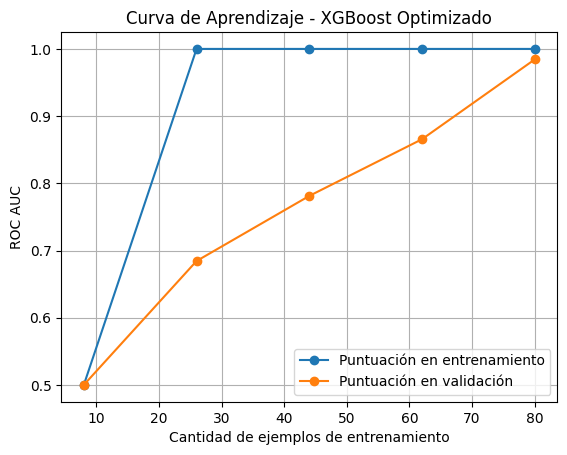


Métricas de XGBoost optimizado:
{'roc_auc': np.float64(0.990625), 'accuracy': np.float64(0.9099999999999999), 'precision': np.float64(0.9), 'recall': np.float64(0.6), 'f1': np.float64(0.6799999999999999)}
Matriz de Confusión de XGBoost optimizado:
[[79  1]
 [ 8 12]]


In [30]:
# Graficamos la curva de aprendizaje del modelo XGBoost optimizado
print("\nCurva de aprendizaje para XGBoost optimizado:")
plot_learning_curve(tuned_xgb, models["XGBoost"]["X"], models["XGBoost"]["y"], title="Curva de Aprendizaje - XGBoost Optimizado")

# Evaluamos el modelo optimizado en el conjunto de datos
metrics_xgb, cm_xgb = evaluate_model(tuned_xgb, models["XGBoost"]["X"], models["XGBoost"]["y"])
print("\nMétricas de XGBoost optimizado:")
print(metrics_xgb)
print("Matriz de Confusión de XGBoost optimizado:")
print(cm_xgb)

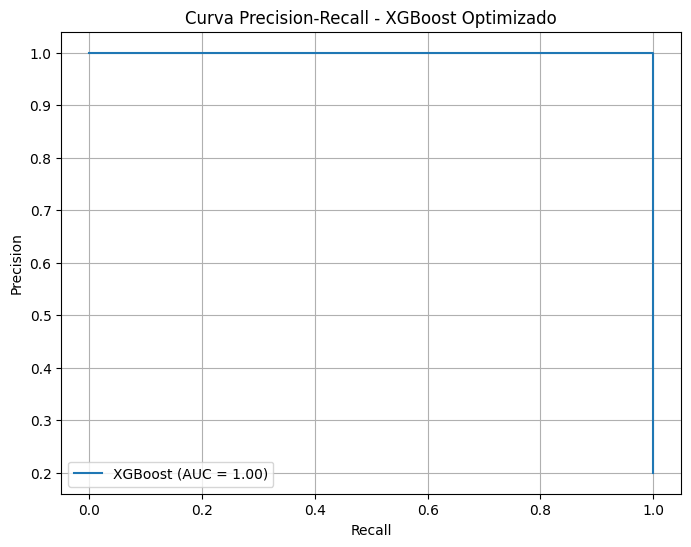

In [31]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# 1. Obtener las probabilidades de clase positiva
y_true = models["XGBoost"]["y"]
y_scores = tuned_xgb.predict_proba(models["XGBoost"]["X"])[:, 1]

# 2. Calcular curva precision-recall
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# 3. Calcular área bajo la curva PR
pr_auc = auc(recall, precision)

# 4. Graficar
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"XGBoost (AUC = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall - XGBoost Optimizado")
plt.legend()
plt.grid(True)
plt.show()

###Conclusión

...


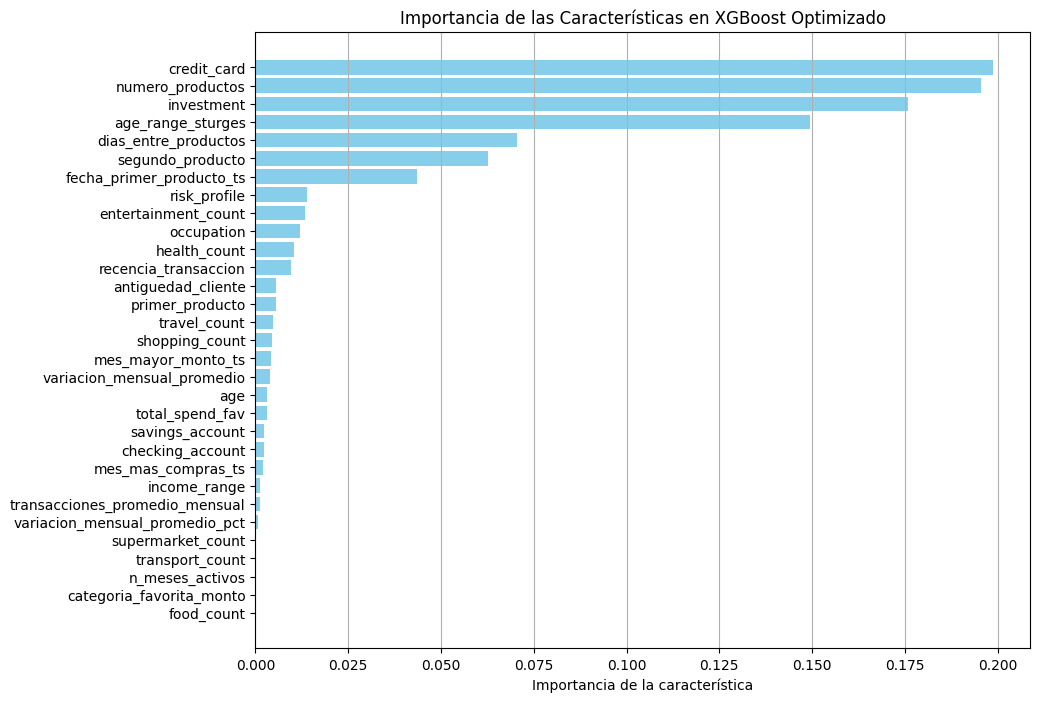

In [32]:
# Extraer la importancia de cada variable del modelo XGBoost optimizado
feature_importances = tuned_xgb.feature_importances_
feature_names = models["XGBoost"]["X"].columns

# Crear un DataFrame para ordenar y visualizar las importancias
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(importance_df["Feature"], importance_df["Importance"], color='skyblue')
plt.xlabel("Importancia de la característica")
plt.title("Importancia de las Características en XGBoost Optimizado")
plt.grid(axis='x')
plt.show()

### Importancia de carácteristicas
        


Siguientes pasos:

1. Asumimos por la curva ROC AUC que no hay sobreentrenamiento. Se puede eveluar de una forma más detallada con mayor tiempo
2. Se va a probar

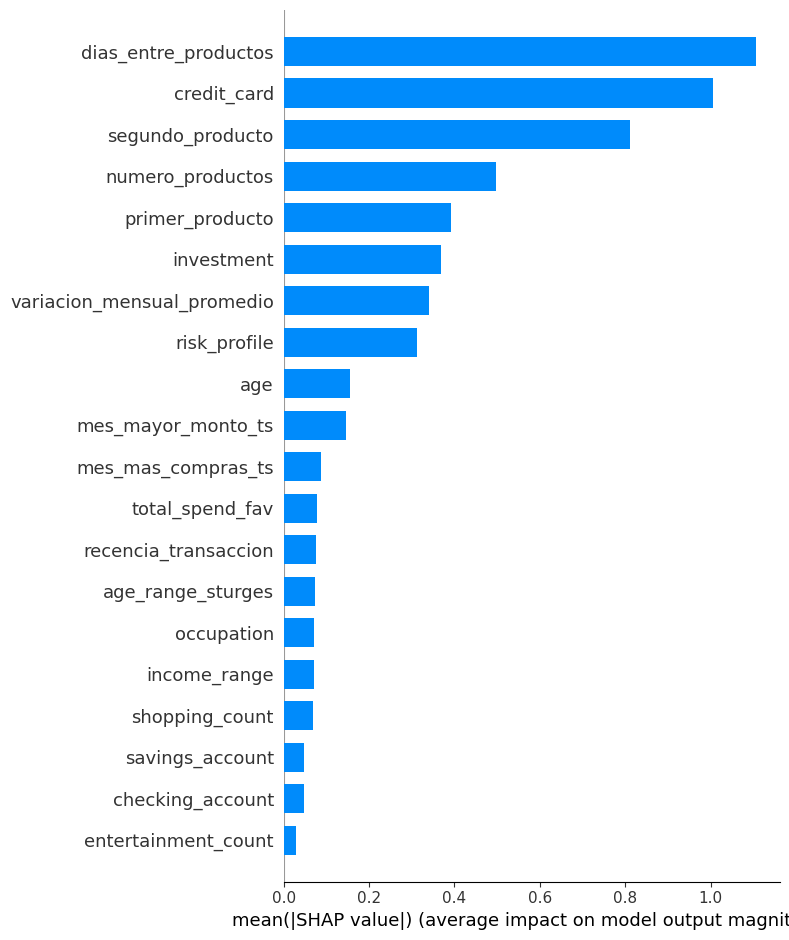

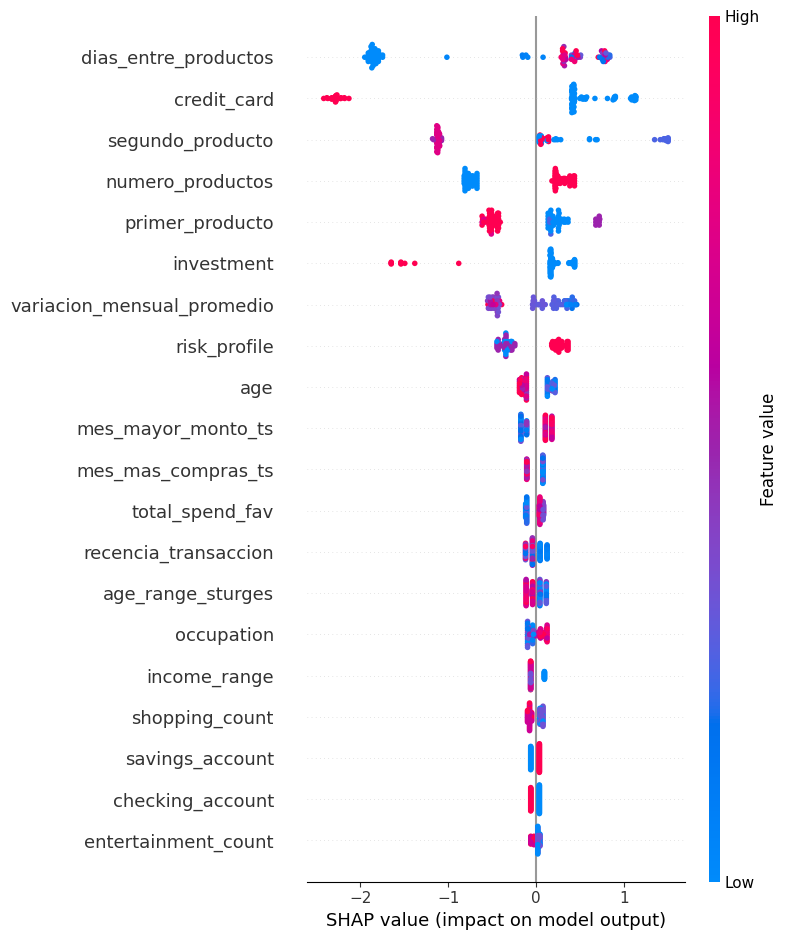

In [33]:
# Crear el objeto Explainer específico para modelos de árbol
explainer = shap.TreeExplainer(tuned_xgb)

# Calcular los valores SHAP para el dataset X
shap_values = explainer.shap_values(models["XGBoost"]["X"])

# Visualizar un resumen de la importancia de las características con SHAP
shap.summary_plot(shap_values, models["XGBoost"]["X"], plot_type="bar")

# O también se puede utilizar el summary plot estándar para ver la distribución de los efectos
shap.summary_plot(shap_values, models["XGBoost"]["X"])

In [34]:
#-Prueba # Si shap_values es una lista (por ejemplo, en clasificación binaria) se suele tomar el índice [1]
# para extraer los valores SHAP correspondientes a la clase positiva.
if isinstance(shap_values, list):
    shap_values = shap_values[1]

# Calcular el valor absoluto medio de los valores SHAP para cada característica.
mean_abs_shap = np.abs(shap_values).mean(axis=0)

# Crear un DataFrame con la información de las características y su importancia
feature_importance_df = pd.DataFrame({
    'Feature': models["XGBoost"]["X"].columns,
    'MeanAbsSHAP': mean_abs_shap
})

# Ordenar las variables de mayor a menor importancia
feature_importance_df.sort_values(by='MeanAbsSHAP', ascending=False, inplace=True)

# Mostrar la lista de importancia
print(feature_importance_df)

                           Feature  MeanAbsSHAP
7             dias_entre_productos     1.107366
11                     credit_card     1.005947
6                 segundo_producto     0.811958
13                numero_productos     0.498639
5                  primer_producto     0.391219
12                      investment     0.368836
22      variacion_mensual_promedio     0.339540
2                     risk_profile     0.312610
0                              age     0.156412
30              mes_mayor_monto_ts     0.145150
29              mes_mas_compras_ts     0.088643
27                 total_spend_fav     0.077460
25            recencia_transaccion     0.075758
4                age_range_sturges     0.074219
3                       occupation     0.070567
1                     income_range     0.070070
17                  shopping_count     0.068384
10                 savings_account     0.047860
9                 checking_account     0.047726
14             entertainment_count     0

Exception ignored in: <function ResourceTracker.__del__ at 0x105299620>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1064f9620>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versi

se puede observae en el análisis SHAP algunas variables que se pueden mencionar.  La fecha del segundo prodcutos e se puede descartar por la imputación de datos. Mientras se puede ver que cuando una persona no tiene crédito o inversiones es más probable que contrate un seguro. Otra variable a resaltar es la de edad en donde se ve que a menor edad es más porbable de contratar uns eguro. También se puede ver que entre menos días entre la contratación de productos la probabilidad de contratar un seguro es menor, a lo mejor es que requiee de un analisis mayor obtener un seguro. 

### Conclusiones después de SHAP "Algunas conclusiones cambian"
...
